In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.dates as mdates
import statistics
import re
import sharedVariables
from sharedVariables import *
import matplotlib
import seaborn as sns
matplotlib.rcParams.update({'errorbar.capsize': 4})
plt.rcParams.update({'font.size': 15})

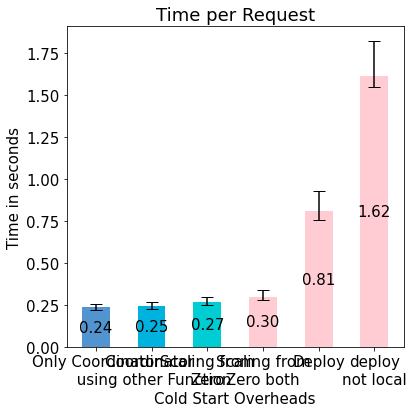

In [11]:
matplotlib.rcParams.update({'errorbar.capsize': 6})

# source = "./data/special-syncmesh/20220202-02-extra-function-30-days"
source = "./data/special-syncmesh/20220205-22-all-functions"

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def convertToTime(s):
    try:
        return (datetime.strptime(s.strip(), "%M:%S.%f") - datetime(1900, 1, 1)).total_seconds()
    except Exception as e:
        return None

def loadTimings(source, func):
    return_data = {}
    with open(source + "/" + func + ".timings") as f:
        return_data = list(chunks(list(filter(None, map(lambda s: convertToTime(s), f.readlines()))), 40))
    return return_data

colors = ["#5294CF", "#00B2DE", "#00CCD3", "#FFCCD3", "#FFCCD3", "#FFCCD3"]

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))

datasets = ["normal", "function", "cold", "cold_both", "deploy", "deploy_notlocal"]
# datasets = ["server-normal", "server-function", "server-cold", "server-cold-both"]

for index, dataset in enumerate(datasets):
    timings = loadTimings(source, dataset)

    timing = timings[0]
    y = statistics.mean(timing)
    y_max = max(timing) - y
    y_min = abs(min(timing) - y)

    bar = ax.bar(0 + (2 * index), y, yerr = [[y_min], [y_max]], color = colors[index], width = 1, ecolor='black')
    ax.bar_label(bar, label_type='center',fmt='%.2f')

# set title and legend
ax.set_title('Time per Request')
ax.set_ylabel("Time in seconds")
ax.set_xlabel("Cold Start Overheads") #Syncmesh Use Case
# ax.legend(labels=datasets)

# box = ax.get_position()
# # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
# fig.autofmt_xdate()
plt.xticks([0,2,4,6,8,10], ["Only Coordinator", "Coordinator \n using other Function", "Scaling from\nZero", "Scaling from\nZero both", "Deploy", "deploy\nnot local"]) #"Loading\nsecondary function"
fig.savefig(f'out/syncmesh_function_timing.png')

plt.show()

In [12]:
# df = pd.read_csv(source + '/all_together.csv')
# print(sns.load_dataset("tips"))
# df = pd.melt(df)
# df['value'] = pd.to_datetime(df['value'], format='%M:%S.%f')
# df['value'] = df['value'].dt.microsecond
# print(df)
# ax = sns.boxplot(x="variable",y="value", data=df)
# ax.set_title('Time per Request')
# ax.set_ylabel("Time in seconds")
# ax.set_xlabel("Cold Start Overheads")

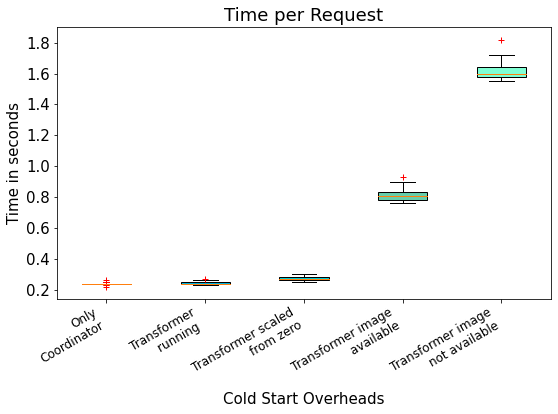

In [34]:
datasets = ["normal", "function", "cold", "deploy", "deploy_notlocal"]
colors = ["#5294CF", "#00B2DE", "#00CCD3", "#66CDAA", "#7FFFD4"]
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
width=0.5
labels_list = ["Only\nCoordinator", "Transformer\nrunning ", "Transformer scaled\nfrom zero", "Transformer image\n available", "Transformer image\nnot available"]

columns = []
for index, dataset in enumerate(datasets):
    timings = loadTimings(source, dataset)

    timing = timings[0]
    y = statistics.mean(timing)
    y_max = max(timing) - y
    y_min = abs(min(timing) - y)
    columns.append(timing)

# set title and legend
ax.set_title('Time per Request')
ax.set_ylabel("Time in seconds")
ax.set_xlabel("Cold Start Overheads") #Syncmesh Use Case, Capabilities?
plt.xticks(fontsize=12)

bplot = ax.boxplot(columns,patch_artist=True,widths=width, sym="r+")
ax.set_xticklabels(labels_list, rotation = 30, ha="right")

for patch,color in zip(bplot["boxes"],colors):
    patch.set_facecolor(color)
fig.savefig(f'out/syncmesh_function_timing.png')
fig.savefig(f'out/syncmesh_function_timing.pdf', format='pdf')

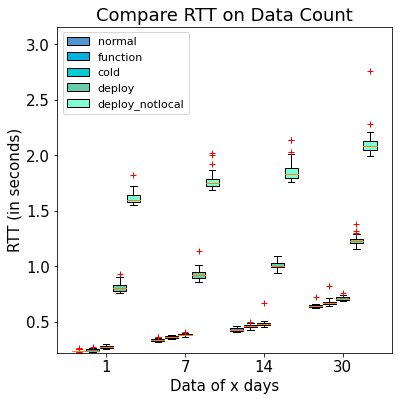

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))


scenarios = ["normal", "function", "cold", "deploy", "deploy_notlocal"]
compare_timings = {}
for dataset in datasets:
    compare_timings[dataset] = {}
    compare_timings[dataset]["1"] = []
    compare_timings[dataset]["7"] = []
    compare_timings[dataset]["14"] = []
    compare_timings[dataset]["30"] = []

    timings = loadTimings(source, dataset)
    for index, scenario in enumerate(['1', '7', '14', "30"]):
        timing = timings[index]
        # y = statistics.mean(timing)
        # y_max = max(timing) - y
        # y_min = abs(min(timing) - y)
        
        

        compare_timings[dataset][scenario] = timing
        # compare_timings[dataset][scenario].append(y_max)
        # compare_timings[dataset][scenario].append(y_min)
        

def drawComparisonGraphTimings(data_groups,group_labels):
    # --- Labels for your data:
    labels_list = ['1', '7', '14', "30"]
    width       = 0.3
    
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_groups[0])) ]

    symbol      = 'r+'
    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
    
    ax = plt.gca()
    ax.set_ylim(ymin,ymax + 0.4)

    # ax.grid(True, linestyle='dotted')
    ax.set_axisbelow(True)

    plt.ylabel("RTT (in seconds)")
    plt.xlabel("Data of x days")
    plt.title("Compare RTT on Data Count")

    space = len(data_groups)/2
    offset = len(data_groups)/2



    # --- Offset the positions per group:

    group_positions = []
    for num, dg in enumerate(data_groups):    
        _off = (0 - space + (0.5+num))
        group_positions.append([x-_off*(width+0.01) for x in xlocations])

    colors = ["#5294CF", "#00B2DE", "#00CCD3", "#66CDAA", "#7FFFD4"]
    colors = colors[::-1]
    for dg, pos, color, label in zip(data_groups, group_positions, colors, group_labels):
        bplot = ax.boxplot(dg, 
                    patch_artist=True,
                    sym=symbol,
                    labels=['']*len(labels_list),        
                    positions=pos, 
                    widths=width, 
        #           notch=False,  
        #           vert=True, 
        #           whis=1.5,
        #           bootstrap=None, 
        #           usermedians=None, 
        #           conf_intervals=None,
        #           patch_artist=False,
                    )
        
        # for patch in bplot['boxes']:
        for patch in bplot['boxes']:
            patch.set_facecolor(color)
            
        patch.set_label(label)

    ax.set_xticks( xlocations )
    ax.set_xticklabels(labels_list)


ax.legend(bplot["boxes"], scenarios, fontsize=11, loc='upper left')
    # x_locator = matplotlib.ticker.FixedLocator(np.array(list(range(1, len(df.index) +1))) * 3)
#     ax.xaxis.set_major_locator(x_locator)
#     ax.legend(loc='upper left') # , bbox_to_anchor=(1.05, 1)
#     ax.set_xticklabels(["1", "7", "14", "30"])


data_groups = []
#res = compare_timings[::-1]
for scenario in ["deploy_notlocal","deploy", "cold", "function", "normal"]: # 
    data_group = []
    for node_number in ["1","7","14","30"]:
            data_group.append(compare_timings[scenario][node_number])
    data_groups.append(data_group)


ax.margins(0.05)
    
drawComparisonGraphTimings(data_groups, ["deploy_notlocal","deploy", "cold", "function", "normal"])

fig.savefig("out/syncmesh_comparison_timings.png")
#    -------------------------
    
    
#     fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
#     for col in datasets: 
#         #ax.plot(3 + df.index * 3, df[col + "_value"], label=col)
#         ax.errorbar(3 + df.index * 3, df[col + "_value"], label=col, yerr = [df[col + "_min"], df[col + "_max"]])
        

#     x_locator = matplotlib.ticker.FixedLocator(np.array(list(range(1, len(df.index) +1))) * 3)
#     ax.xaxis.set_major_locator(x_locator)
#     ax.legend(loc='upper left') # , bbox_to_anchor=(1.05, 1)
#     ax.set_xticklabels(["1", "7", "14", "30"])



# drawComparisonGraphTimings(compare_table_timing)